In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import argparse
import yaml
from flax.training import train_state, checkpoints
import optax
from functools import partial
import pandas as pd

from irbfn_mpc.dynamics import integrate_st_mult
from irbfn_mpc.model import WCRBFNet, DeeperWCRBFNet, MLP
from flax_rbf.flax_rbf import gaussian, inverse_quadratic, gaussian_narrow

from irbfn_mpc.nonlinear_dmpc import NMPCPlanner

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(context="talk", style="white", palette="pastel", font="Times New Roman")

In [3]:
# explicit nmpc table
npz_path = "/data/tables/frenet/constraints_12ey_7delta_11vxcar_11vycar_5vxgoal_11wz_11epsi_3curv_mu1.0999999999999999_cs5.0_sorted.npz"
data = np.load(npz_path)
inputs, outputs = data["inputs"], data["outputs"]

In [4]:
@partial(jax.vmap, in_axes=[0, None])
@jax.jit
def get_closest_ind(input, all_inputs):
    diff = all_inputs - input
    ind = jnp.argmin(jnp.linalg.norm(diff, axis=1))
    return ind

In [27]:
config_f = "configs/dnmpc_fixed_constraint_centers_mode_highk.yaml"
ckpt = "ckpts/dnmpc_fixed_constraint_centers_mode_highk/checkpoint_5900"


In [ ]:
with open(config_f, "r") as f:
    config_dict = yaml.safe_load(f)
conf = argparse.Namespace(**config_dict)

wcrbf = DeeperWCRBFNet(
    in_features=conf.in_features,
    out_features=conf.out_features,
    num_kernels=conf.num_kernels,
    basis_func=eval(conf.basis_func),
    num_regions=conf.num_regions,
    lower_bounds=conf.lower_bounds,
    upper_bounds=conf.upper_bounds,
    dimension_ranges=conf.dimension_ranges,
    activation_idx=conf.activation_idx,
    delta=conf.delta,
)
rng = jax.random.PRNGKey(conf.seed)
rng, init_rng = jax.random.split(rng)
params = wcrbf.init(init_rng, jnp.ones((1, conf.in_features)))
optim = optax.chain(optax.clip_by_global_norm(0.1), optax.adam(conf.lr))
state = train_state.TrainState.create(
    apply_fn=wcrbf.apply, params=params, tx=optim
)
restored_state = checkpoints.restore_checkpoint(
    ckpt_dir=ckpt, target=state
)

In [28]:
@jax.jit
def pred_step(state, x):
    y = state.apply_fn(state.params, x)
    return y

In [48]:
# goal grid on xy
ey = np.linspace(0.0, 2.0, 20)
epsi = np.linspace(0.0, 1.0, 20)
ey_m, epsi_m = np.meshgrid(ey, epsi, indexing="ij")
ey = ey_m.flatten()
epsi = epsi_m.flatten()
zs = np.zeros_like(ey)
vc = 1.076 * np.ones_like(ey)
vg = 4.0 * np.ones_like(ey)
tg = np.mod(-1.3 * np.ones_like(ey), np.pi)

# inputs
test_inputs = np.column_stack((ey, zs, vc, zs, vg, zs, epsi, zs))

In [49]:
import chex
chex.clear_trace_counter()

In [50]:
# output from irbfn
pred_u_irbfn = pred_step(restored_state, test_inputs)
# pred_u_irbfn = pred_step(restored_state, test_inputs_dv)

In [51]:
# output from explicit table
inds_explicit = get_closest_ind(test_inputs, inputs)


In [52]:
pred_u_explicit = outputs[inds_explicit].reshape((-1, 10), order="F")

In [53]:
# errors = pred_u_irbfn - pred_u_explicit[:, [0, 5]]
errors = pred_u_irbfn - pred_u_explicit

In [54]:
first_accl_actual_df = pd.DataFrame({"ey": test_inputs[:, 0], "epsi": test_inputs[:, -2], "accl_0": pred_u_explicit[:,  0]}, columns=["ey", "epsi", "accl_0"])
first_sv_actual_df = pd.DataFrame({"ey": test_inputs[:, 0], "epsi": test_inputs[:, -2], "sv_0": pred_u_explicit[:, 5]}, columns=["ey", "epsi", "sv_0"])
first_accl_predicted_df = pd.DataFrame({"ey": test_inputs[:, 0], "epsi": test_inputs[:, -2], "accl_0": pred_u_irbfn[:,  0]}, columns=["ey", "epsi", "accl_0"])
first_sv_predicted_df = pd.DataFrame({"ey": test_inputs[:, 0], "epsi": test_inputs[:, -2], "sv_0": pred_u_irbfn[:, 5]}, columns=["ey", "epsi", "sv_0"])


In [55]:
first_accl_actual_df = first_accl_actual_df.pivot(index="epsi", columns="ey", values="accl_0")
first_sv_actual_df = first_sv_actual_df.pivot(index="epsi", columns="ey", values="sv_0")
first_accl_predicted_df = first_accl_predicted_df.pivot(index="epsi", columns="ey", values="accl_0")
first_sv_predicted_df = first_sv_predicted_df.pivot(index="epsi", columns="ey", values="sv_0")

Text(0.5, 1.0, 'Actual First Accl')

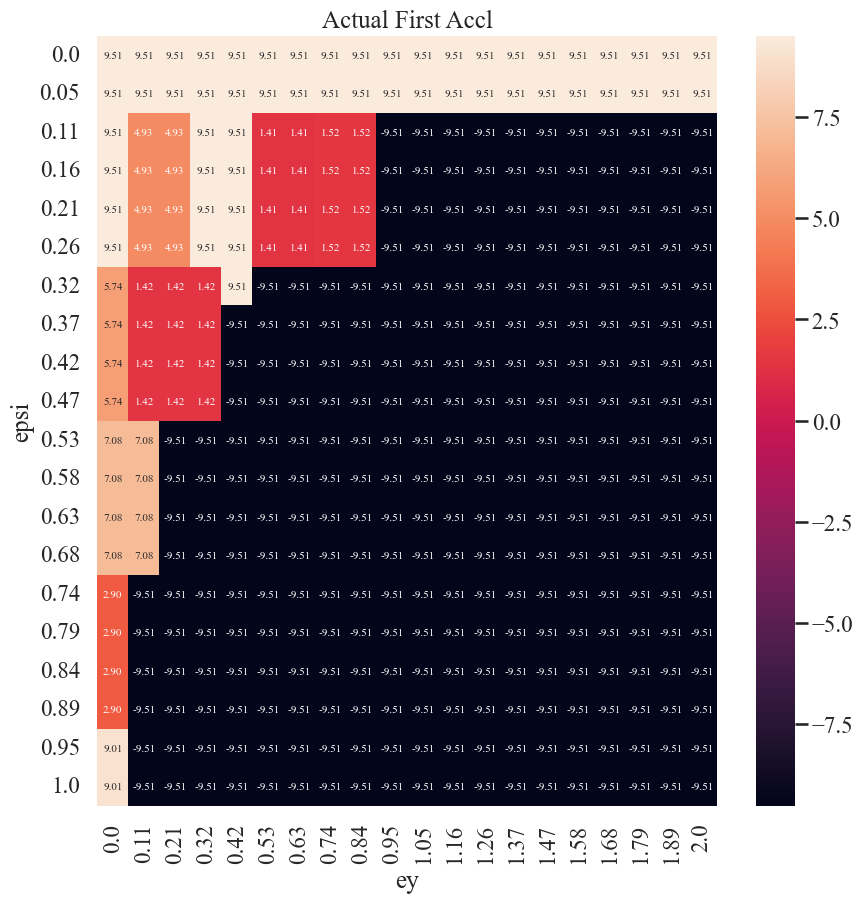

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(first_accl_actual_df.round(3), annot=True, annot_kws={"fontsize":8}, fmt=".2f", xticklabels=first_accl_actual_df.columns.values.round(2), yticklabels=first_accl_actual_df.index.values.round(2))
plt.title("Actual First Accl")

Text(0.5, 1.0, 'Actual First SV')

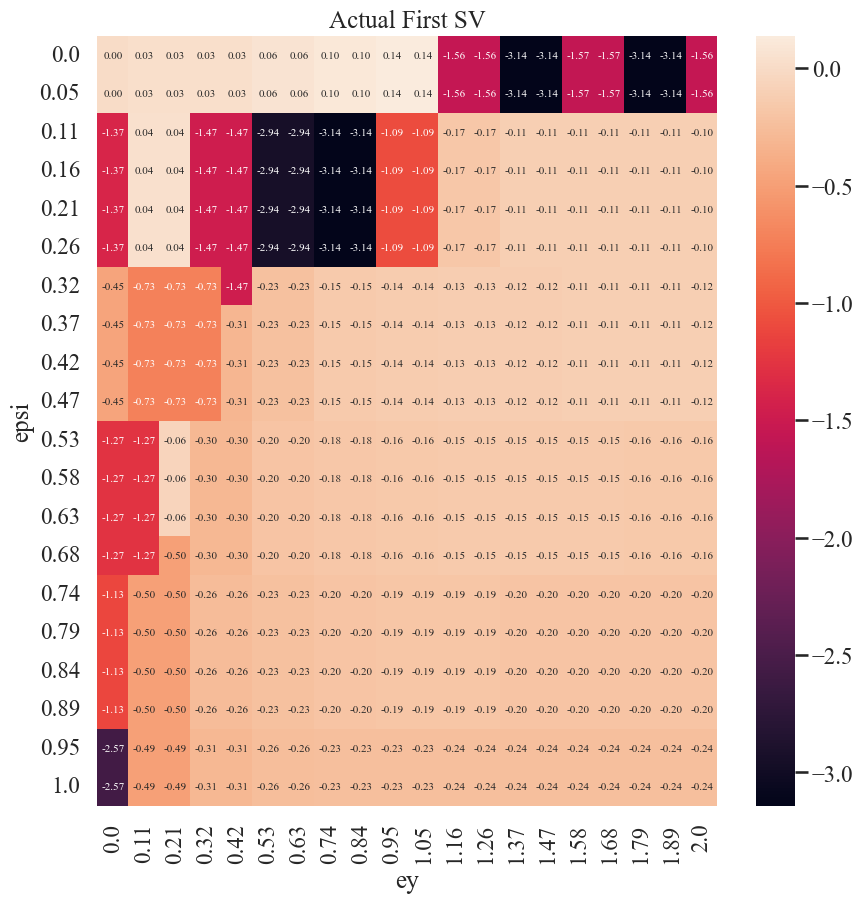

In [57]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(first_sv_actual_df.round(3), annot=True, annot_kws={"fontsize":8}, fmt=".2f", xticklabels=first_sv_actual_df.columns.values.round(2), yticklabels=first_sv_actual_df.index.values.round(2))
plt.title("Actual First SV")

Text(0.5, 1.0, 'Predicted First Accl')

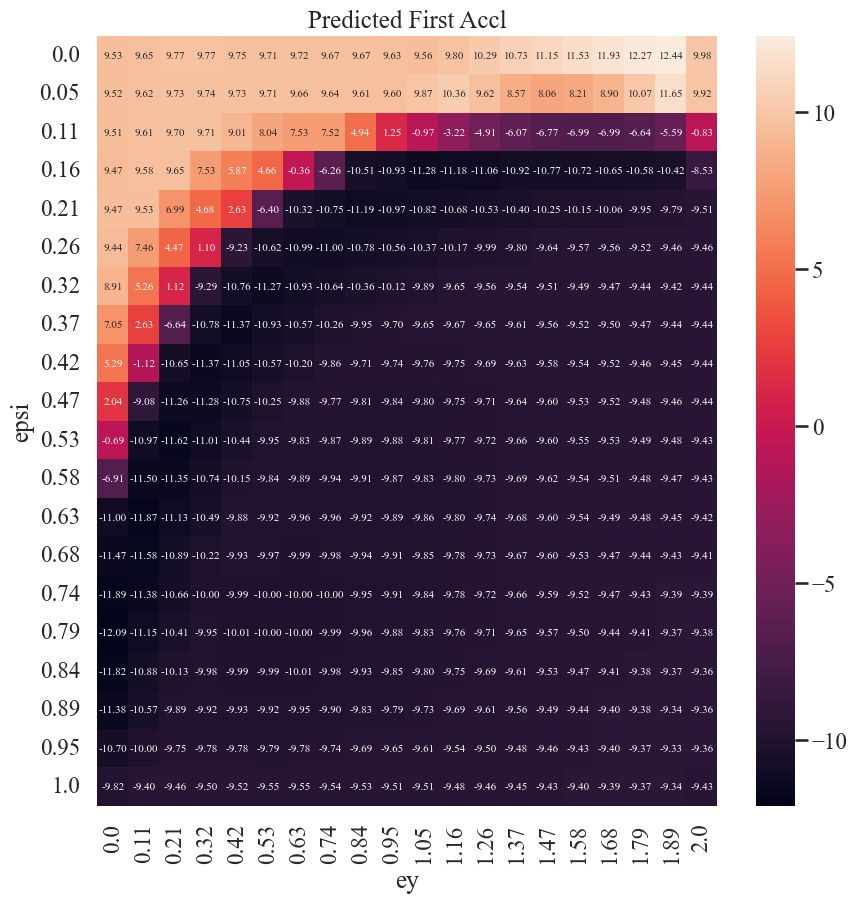

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(first_accl_predicted_df.round(3), annot=True, annot_kws={"fontsize":8}, fmt=".2f", xticklabels=first_accl_predicted_df.columns.values.round(2), yticklabels=first_accl_predicted_df.index.values.round(2))
plt.title("Predicted First Accl")

Text(0.5, 1.0, 'Predicted First SV')

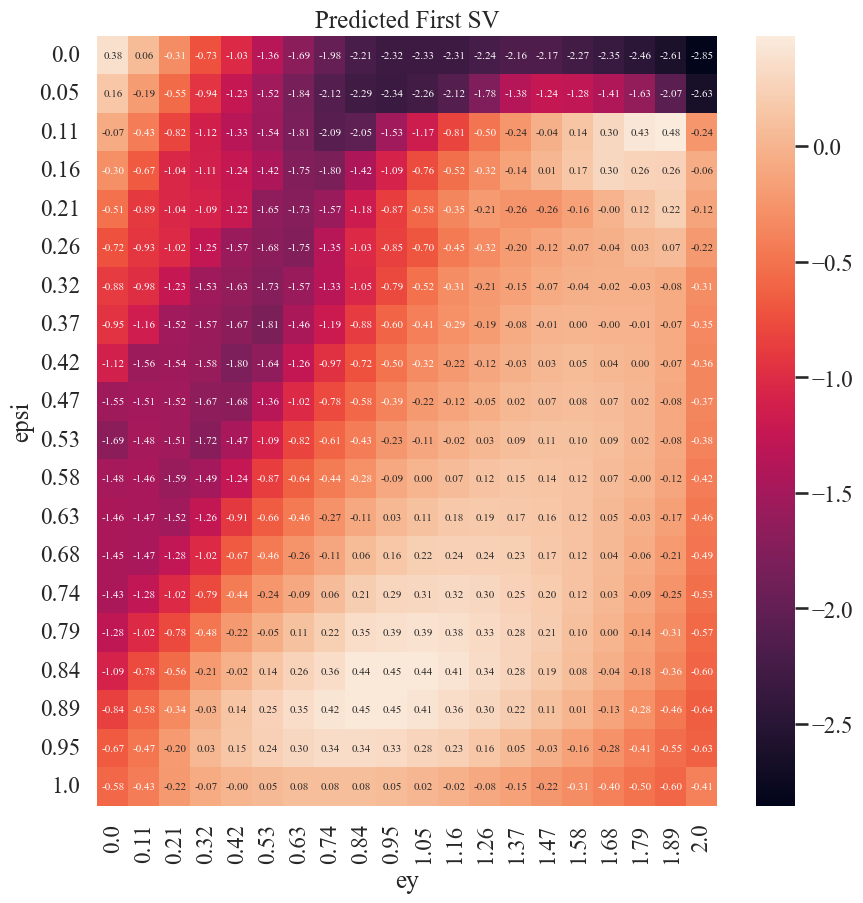

In [59]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(first_sv_predicted_df.round(3), annot=True, annot_kws={"fontsize":8}, fmt=".2f", xticklabels=first_sv_predicted_df.columns.values.round(2), yticklabels=first_sv_predicted_df.index.values.round(2))
plt.title("Predicted First SV")

In [60]:
df = pd.DataFrame({"ey": test_inputs[:, 0], "epsi": test_inputs[:, -2], "err": list(errors)}, columns=["ey", "epsi", "err"])

In [61]:
first_accl_df = pd.DataFrame({"ey": test_inputs[:, 0], "epsi": test_inputs[:, -2], "err": errors[:, 0]}, columns=["ey", "epsi", "err"])

In [62]:
first_accl_df = first_accl_df.pivot(index="epsi", columns="ey", values="err")

Text(0.5, 1.0, 'First acceleration input error against LUT')

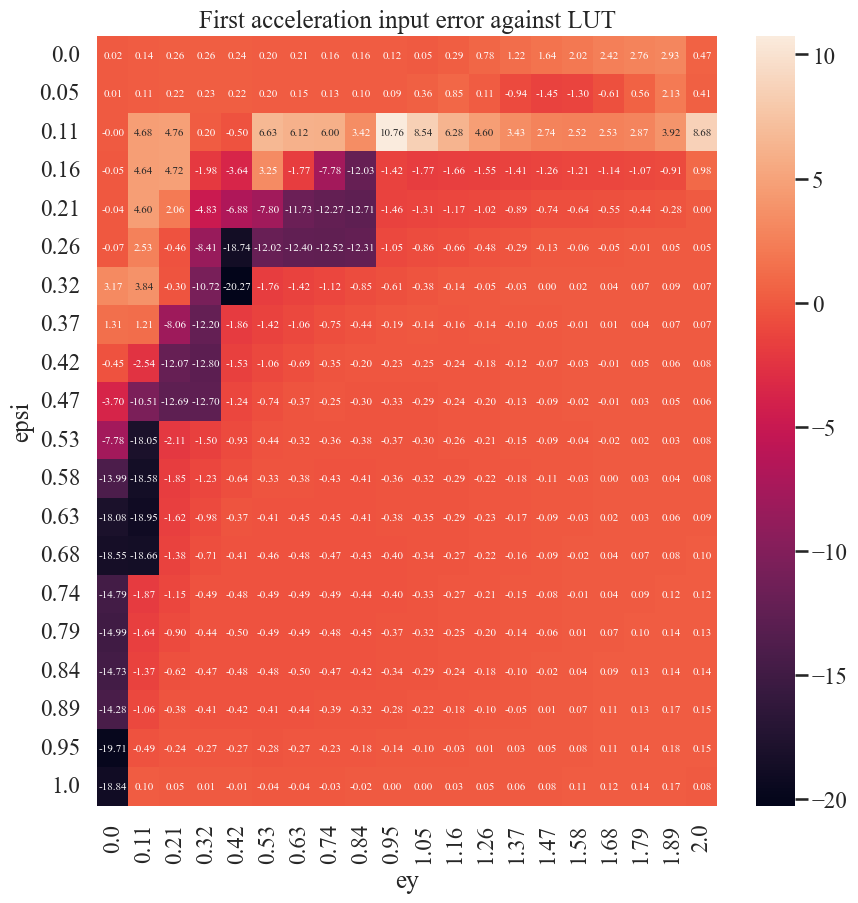

In [63]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(first_accl_df.round(3), annot=True, annot_kws={"fontsize":8}, fmt=".2f", xticklabels=first_accl_df.columns.values.round(2), yticklabels=first_accl_df.index.values.round(2))
plt.title("First acceleration input error against LUT")

In [64]:
first_vs_df = pd.DataFrame({"ey": test_inputs[:, 0], "epsi": test_inputs[:, -2], "err": errors[:, 5]}, columns=["ey", "epsi", "err"])

In [65]:
first_vs_df = first_vs_df.pivot(index="epsi", columns="ey", values="err")

Text(0.5, 1.0, 'First steering velocity input error against LUT')

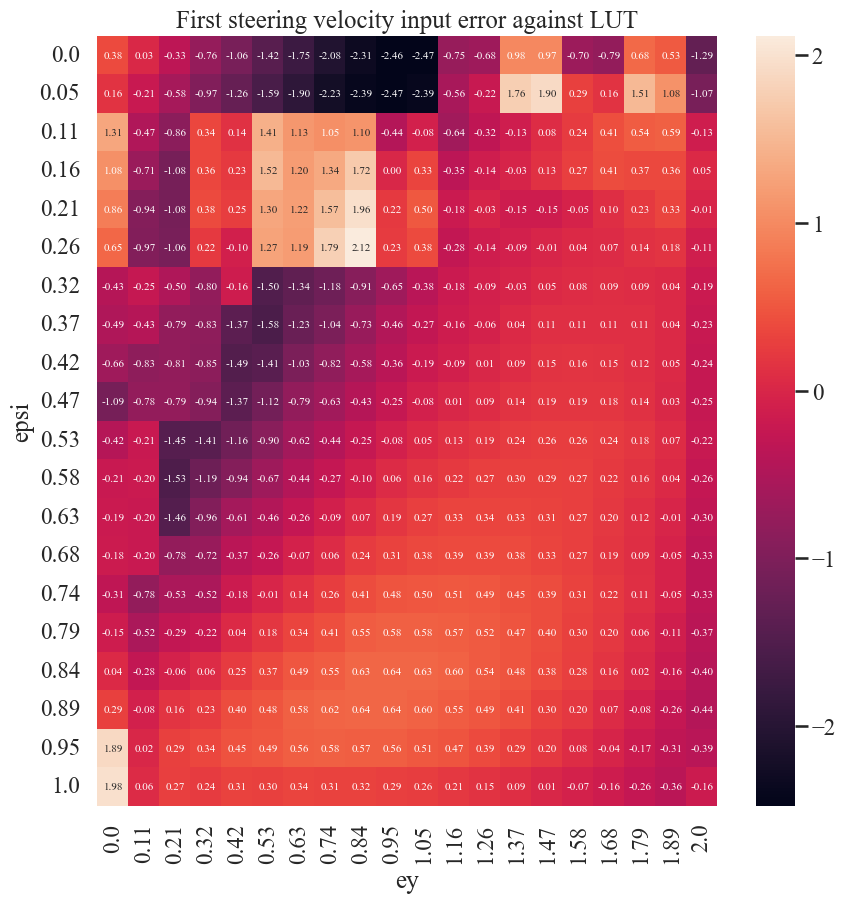

: 

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(first_vs_df.round(3), annot=True, annot_kws={"fontsize":8}, fmt=".2f", xticklabels=first_vs_df.columns.values.round(2), yticklabels=first_vs_df.index.values.round(2))
plt.title("First steering velocity input error against LUT")